In [1]:
import torch
import torch.nn as nn
import math
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
torch.set_printoptions(precision=2, sci_mode=False)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return self.pe[:, :x.size(1)]

In [2]:
class multihead(nn.Module):
    def __init__(self, dmodel, h):
        super().__init__()

        self.dk=dmodel/h #queries & keys dimension

        assert (
            self.dk*h == dmodel
        ), "Embedding size needs to be divisible by heads"

        self.dk = int(self.dk)
        self.dv = self.dk

        self.h = h

        self.Wq = nn.Linear(dmodel, dmodel, bias=False)
        self.Wk = nn.Linear(dmodel, dmodel, bias=False)
        self.Wv = nn.Linear(dmodel, dmodel, bias=False)
        self.Wo = nn.Linear(dmodel, dmodel, bias=False)

        self.attn_pattern = None

    def attention(self, q, k, v, mask=None): #vect of size dmodel/h
        product = torch.matmul(q, k.transpose(-2, -1)) # [batch, h, seq, dmodel/h] . [batch, h, dmodel/h, seq] = [batch, h, seq, seq]

        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20"))
            
        product = product / math.sqrt(self.dk)
        score = torch.softmax(product, dim=-1)
        
        return torch.matmul(score, v) # [batch, h, seq, seq] . [batch, h, seq, dmodel/h] = [batch, h, seq, dmodel/h]

        
    def forward(self, q, k, v, mask=None):
        
        h = self.h
        dv= self.dv
        dk= self.dk

        b, t, dmod = k.size()
        t_q= q.size(1)

        q = self.Wq(q)
        k = self.Wk(k)
        v = self.Wv(v)

        q = q.view(b, t_q, h, dk).transpose(1, 2) # [batch, seq, dmodel] -> [batch, h, seq, dmodel/h]
        k = k.view(b, t, h, dk).transpose(1, 2)
        v = v.view(b, t, h, dv).transpose(1, 2)
        
        out = self.attention(q, k, v, mask)
        out = out.transpose(1, 2).contiguous().view(b, t_q, dmod) # [batch, h, seq, dmodel/h] -> [batch, seq, dmodel]
        out = self.Wo(out)
        return out

In [3]:
class feedForward(nn.Module):
    def __init__(self, dmodel, dff):
        super().__init__()
        self.linear1 = nn.Linear(dmodel, dff)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(dff, dmodel)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, dmodel, h, dff, pdrop):
        super().__init__()
        self.multihead = multihead(dmodel, h)
        self.layerNorm1 = nn.LayerNorm(dmodel)
        self.FF = feedForward(dmodel, dff)
        self.layerNorm2 = nn.LayerNorm(dmodel)
        self.dropout1 = nn.Dropout(pdrop)
        self.dropout2 = nn.Dropout(pdrop)

    def forward(self, q, k, v, mask):
        subL1 = self.multihead(q, k, v, mask)
        y = self.layerNorm1(q + self.dropout1(subL1))
        subL2 = self.FF(y)
        y = self.layerNorm2(y + self.dropout2(subL2))
        return y

In [5]:
class Decoder(nn.Module):
    def __init__(self, dmodel, h, dff, pdrop):
        super().__init__()
        self.multihead = multihead(dmodel, h)
        self.norm = nn.LayerNorm(dmodel)
        self.dropout = nn.Dropout(pdrop)
        self.block = TransformerBlock(dmodel, h, dff, pdrop)
        
    def forward(self, x, enc_output, src_mask, trg_mask=None):
        mask_att = self.multihead(x, x, x, trg_mask)
        y = self.norm(x + self.dropout(mask_att))
        y = self.block(y, enc_output, enc_output, src_mask)
        return y

In [6]:
class Scheduler(_LRScheduler): #mainly inspired by https://kikaben.com/transformers-training-details/
    def __init__(self, optim, dmodel, warmup_steps):
        self.dmodel = dmodel
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optim.param_groups)
        super().__init__(optim)
   
    def get_lr(self):
        step_num = self._step_count
        dmodel = self.dmodel
        warmup_steps = self.warmup_steps
    
        lrate = (dmodel**(-0.5) * min(step_num**(-0.5), step_num*warmup_steps**(-1.5)))*1
        return [lrate]

In [7]:
def toTokens(logits):
    return torch.argmax(logits,dim=-1)


class Transformer(nn.Module):
    def __init__(self, N, dmodel, h, dff, pdrop, src_vocab_size, trg_vocab_size, max_seq_length, PAD_src, PAD_trg, BOS_trg, EOS_trg):
        super().__init__()

        self.dmodel = dmodel
        self.max_seq_length = max_seq_length
        self.trg_vocab_size = trg_vocab_size
        self.PAD_src = PAD_src
        self.PAD_trg = PAD_trg
        self.BOS_trg = BOS_trg
        self.EOS_trg = EOS_trg

        self.src_embedding = nn.Embedding(src_vocab_size, dmodel)
        self.trg_embedding = nn.Embedding(trg_vocab_size, dmodel)
        self.positional_encoding = PositionalEncoding(dmodel, max_seq_length)

        self.encoder = nn.ModuleList([TransformerBlock(dmodel, h, dff, pdrop) for _ in range(N)])
        self.decoder = nn.ModuleList([Decoder(dmodel, h, dff, pdrop) for _ in range(N)])

        self.linear = nn.Linear(dmodel, trg_vocab_size)
        self.dropout1 = nn.Dropout(pdrop)
        self.dropout2 = nn.Dropout(pdrop)


    def create_mask(self, src, trg=None):
        src_mask = (src != self.PAD_src).unsqueeze(1).unsqueeze(2)
        if trg is None:
            return src_mask
        else:
            trg_mask = (trg != self.PAD_trg).unsqueeze(1).unsqueeze(3)
            trg_len = trg.size(1)
            diago = torch.tril(torch.ones(1, trg_len, trg_len, device=device)).bool()
            trg_mask = trg_mask & diago
            return src_mask, trg_mask


    def forward(self, src, trg):

        assert (
            src.size(0) == trg.size(0)
        ), "batch src and batch trg are not equals"

        src_mask, trg_mask = self.create_mask(src, trg)
        
        src_embed = self.dropout1(self.src_embedding(src) + self.positional_encoding(src))
        trg_embed = self.dropout2(self.trg_embedding(trg) + self.positional_encoding(trg))

        enc_out = src_embed
        for enc_layer in self.encoder:
            enc_out = enc_layer(enc_out, enc_out, enc_out, src_mask)

        dec_out = trg_embed
        for dec_layer in self.decoder:
            dec_out = dec_layer(dec_out, enc_out, src_mask, trg_mask)

        output = self.linear(dec_out)
        
        return output 


    def infer(self, src, trg):#infer the last token of the trg, knowing the src and all except the last token of trg
        self.eval()
        with torch.no_grad():
            output = self(src, trg[:,:-1])
            return toTokens(output)


    def trainer(self, dataloader, epoch=1):
        criterion = nn.CrossEntropyLoss(ignore_index=self.PAD_trg, label_smoothing = 0.1)
        optimizer = optim.Adam(self.parameters() ,betas = (0.9, 0.98), eps = 1.0e-9)
        scheduler = Scheduler(optimizer, self.dmodel, warmup_steps = 4000)

        errors_list =  []

        self.train()
        for epoch in range(epoch):
            error = 0

            for i, (src, trg) in enumerate(dataloader):
                optimizer.zero_grad()
                pred = self(src, trg[:,:-1])
                pred = pred.contiguous().view(-1, trg_vocab_size)
                y = trg[:,1:].contiguous().view(-1)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()
                error += loss.item()

                print('Batch', i, ', Loss', error)
                errors_list.append(error)
                error = 0

        plt.plot(errors_list)
        plt.title("Errors")
        plt.show()

    def predict(self, src):
        self.eval()
        with torch.no_grad():

            src = src_tokenizer(src, max_length=self.max_seq_length, padding='max_length', truncation=True)
            src = torch.tensor(src['input_ids'], device=device)
            enc_out = self.dropout1(self.src_embedding(src) + self.positional_encoding(src))
            
            src_mask = self.create_mask(src)
            for enc_layer in self.encoder:
                enc_out = enc_layer(enc_out, enc_out, enc_out, src_mask)

            Tokens_ids = torch.tensor(self.BOS_trg).repeat(1, 1).to(device) #beginning of the sentence to predict

            for _ in range(self.max_seq_length):

                dec_out = self.dropout2(self.trg_embedding(Tokens_ids) + self.positional_encoding(Tokens_ids))

                _, trg_mask = self.create_mask(src, Tokens_ids)
                for dec_layer in self.decoder:
                    dec_out = dec_layer(dec_out, enc_out, src_mask, trg_mask)
                    
                transfo_out = self.linear(dec_out)

                transfo_out = transfo_out[:,-1:]
                tok = toTokens(transfo_out)

                if tok.item() == self.EOS_trg:
                    break

                Tokens_ids = torch.cat((Tokens_ids, tok), dim=1)

            out = Tokens_ids[:, 1:]# delete the bos
            return trg_tokenizer.batch_decode(out)

In [8]:
from transformers import AutoTokenizer

src_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
trg_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
src_vocab_size = src_tokenizer.vocab_size
trg_vocab_size = trg_tokenizer.vocab_size

PAD_src = src_tokenizer.pad_token_id
PAD_trg = trg_tokenizer.pad_token_id
#BOS_trg = trg_tokenizer.bos_token_id #trg_tokenizer.cls_token_id
#EOS_trg = trg_tokenizer.eos_token_id #trg_tokenizer.sep_token_id
BOS_trg = trg_tokenizer.cls_token_id
EOS_trg = trg_tokenizer.sep_token_id

N=6; dmodel=512; h=8; dff=2048; pdrop=0.1; max_length = 40; device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datasets import load_dataset #original size=127085
books = load_dataset("opus_books", "en-fr")['train']['translation']#[:100]
en_books = [example['en'] for example in books]
fr_books = [example['fr'] for example in books]

src = src_tokenizer(en_books, max_length=max_length, padding='max_length', truncation=True)
trg = trg_tokenizer(fr_books, max_length=max_length, padding='max_length', truncation=True)

src = torch.tensor(src['input_ids'], device=device)
trg = torch.tensor(trg['input_ids'], device=device)

dataset = TensorDataset(src, trg)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batch 0 , Loss 10.448636054992676
Batch 1 , Loss 10.466205596923828
Batch 2 , Loss 10.432369232177734
Batch 3 , Loss 10.440464973449707
Batch 4 , Loss 10.44710922241211
Batch 5 , Loss 10.42172908782959
Batch 6 , Loss 10.403752326965332
Batch 7 , Loss 10.403276443481445
Batch 8 , Loss 10.402520179748535
Batch 9 , Loss 10.38390064239502
Batch 10 , Loss 10.389504432678223
Batch 11 , Loss 10.371484756469727
Batch 12 , Loss 10.35954475402832
Batch 13 , Loss 10.334527969360352
Batch 14 , Loss 10.296371459960938
Batch 15 , Loss 10.288613319396973
Batch 16 , Loss 10.262613296508789
Batch 17 , Loss 10.270700454711914
Batch 18 , Loss 10.23958683013916
Batch 19 , Loss 10.22644329071045
Batch 20 , Loss 10.155227661132812
Batch 21 , Loss 10.130334854125977
Batch 22 , Loss 10.13602352142334
Batch 23 , Loss 10.086795806884766
Batch 24 , Loss 10.055224418640137
Batch 25 , Loss 10.080991744995117
Batch 26 , Loss 10.030160903930664
Batch 27 , Loss 10.015820503234863
Batch 28 , Loss 9.952250480651855
Bat

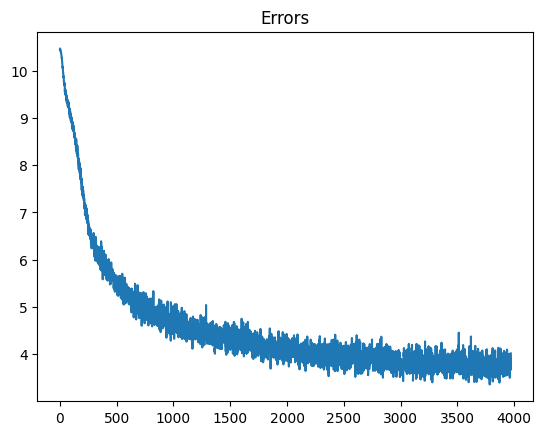

In [9]:
transformer = Transformer(N, dmodel, h, dff, pdrop, src_vocab_size, trg_vocab_size, max_length, PAD_trg, PAD_trg, BOS_trg, EOS_trg).to(device)
transformer.trainer(train_dataloader)

In [25]:
transformer.predict(['I love you'])

['Je vous aime.']